# Superhero Attributes and Power Classification

**DSCI 4411 - Fundamentals of Data Mining**  
**The American University in Cairo - Fall 2025**

This project explores classification and clustering techniques using a dataset of superheroes with various attributes such as powers, skills, physical traits, and biography data.

## Enhanced Analysis with Multiple Models & Techniques

## 1. Setup and Data Loading

In [1]:
# Install additional packages if needed
# !pip install xgboost lightgbm catboost

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier, 
                              HistGradientBoostingClassifier, VotingClassifier, StackingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import warnings
warnings.filterwarnings('ignore')

# Try to import XGBoost (optional)
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not installed, skipping...")

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 7)

In [2]:
# Load the dataset
df = pd.read_csv('superhero dataset.csv')
print(f"Dataset Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nTarget Distribution:")
print(df['is_good'].value_counts(normalize=True))
df.head()

Dataset Shape: (1200, 17)

Columns: ['height_cm', 'weight_kg', 'age', 'years_active', 'training_hours_per_week', 'civilian_casualties_past_year', 'power_level', 'public_approval_rating', 'super_strength', 'flight', 'energy_projection', 'telepathy', 'healing_factor', 'shape_shifting', 'invisibility', 'telekinesis', 'is_good']

Target Distribution:
is_good
1    0.65
0    0.35
Name: proportion, dtype: float64


,height_cm,weight_kg,age,years_active,training_hours_per_week,civilian_casualties_past_year,power_level,public_approval_rating,super_strength,flight,energy_projection,telepathy,healing_factor,shape_shifting,invisibility,telekinesis,is_good
0,189.9,81.9,33,10,32.6,2,28.4,62.9,0,1,0,1,0,0,1,1,1
1,177.2,73.6,58,22,41.9,2,67.3,41.4,0,0,0,0,0,0,1,0,1
2,193.0,81.8,47,6,22.3,0,95.9,96.8,0,1,0,0,0,1,1,0,0
3,210.5,88.1,62,26,25.0,4,71.8,53.2,1,0,0,1,0,0,0,0,1
4,175.3,80.7,43,28,24.9,3,81.3,36.1,0,0,0,1,1,1,1,1,0


In [3]:
# Create figures directory
import os
os.makedirs('figures', exist_ok=True)

## 2. Exploratory Data Analysis (EDA)

In [4]:
# Statistical summary
print("Statistical Summary:")
df.describe()

Statistical Summary:


,height_cm,weight_kg,age,years_active,training_hours_per_week,civilian_casualties_past_year,power_level,public_approval_rating,super_strength,flight,energy_projection,telepathy,healing_factor,shape_shifting,invisibility,telekinesis,is_good
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000
mean,181.217833,80.422250,42.325833,15.095833,29.483500,1.893333,70.182333,64.615833,0.287500,0.314167,0.300833,0.304167,0.308333,0.316667,0.31500,0.318333,0.650000
std,18.831243,14.616758,11.323641,8.553905,10.117866,1.896915,15.286139,18.543736,0.452785,0.464377,0.458812,0.460245,0.461998,0.465370,0.46471,0.466024,0.477168
min,150.000000,45.000000,18.000000,0.000000,1.000000,0.000000,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,167.500000,70.375000,35.000000,8.000000,22.800000,1.000000,59.775000,52.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,181.000000,80.200000,42.000000,15.000000,29.400000,1.000000,70.200000,64.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000
75%,193.525000,90.100000,50.000000,22.000000,36.400000,3.000000,81.000000,77.425000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
max,250.000000,127.900000,84.000000,29.000000,61.000000,13.000000,100.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


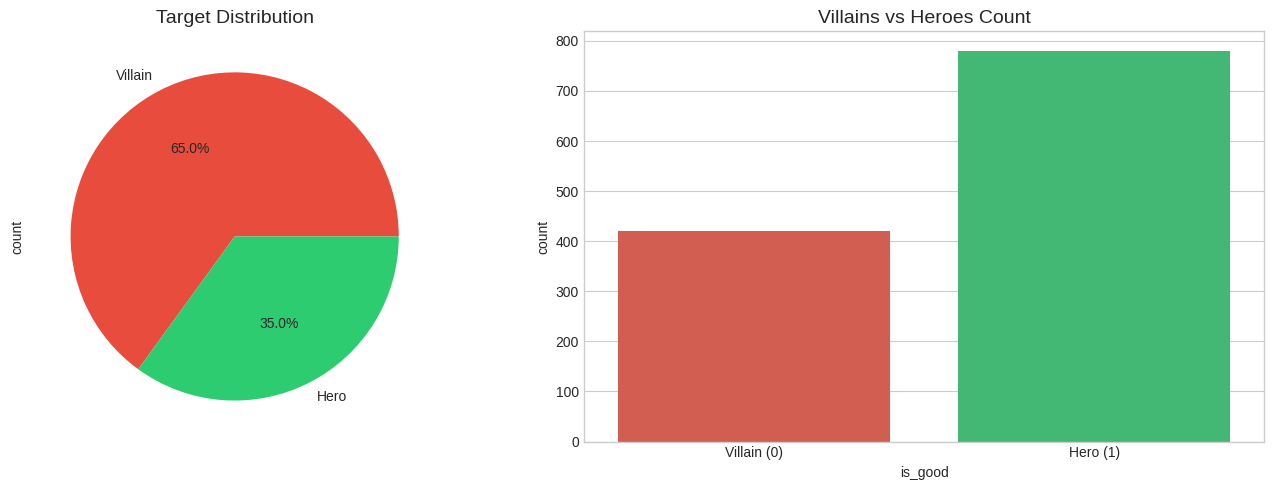

In [5]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#e74c3c', '#2ecc71']
df['is_good'].value_counts().plot(kind='pie', ax=axes[0], colors=colors, 
                                   labels=['Villain', 'Hero'], autopct='%1.1f%%')
axes[0].set_title('Target Distribution', fontsize=14)

sns.countplot(data=df, x='is_good', palette=colors, ax=axes[1])
axes[1].set_xticklabels(['Villain (0)', 'Hero (1)'])
axes[1].set_title('Villains vs Heroes Count', fontsize=14)

plt.tight_layout()
plt.savefig('figures/target_distribution.png', dpi=150)
plt.show()

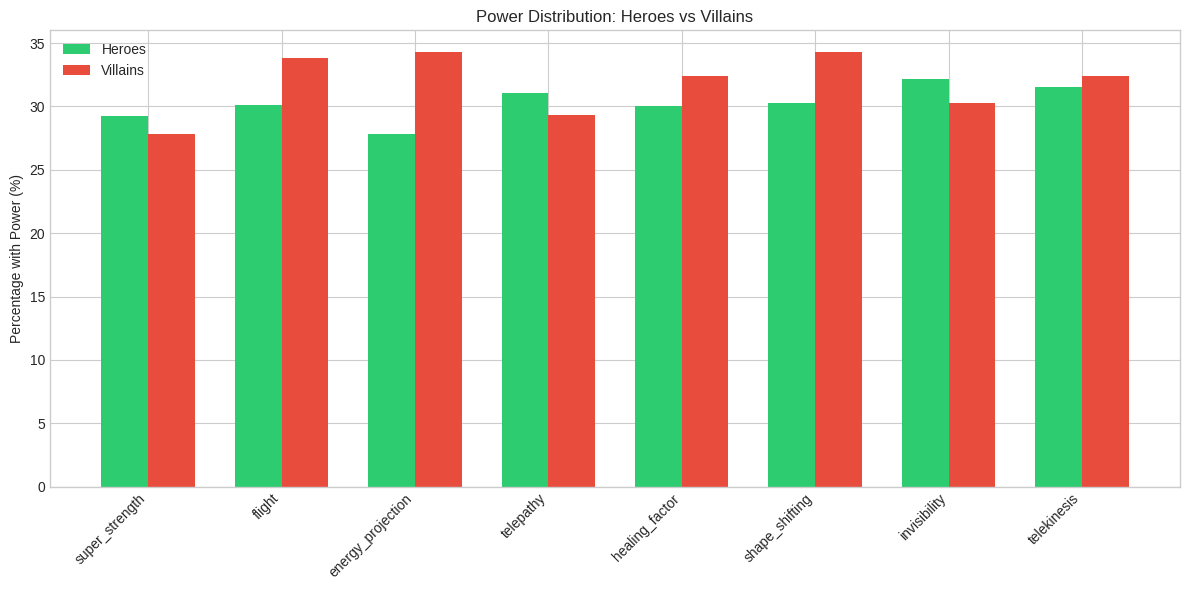

In [6]:
# Power distribution analysis
power_cols = ['super_strength', 'flight', 'energy_projection', 'telepathy', 
              'healing_factor', 'shape_shifting', 'invisibility', 'telekinesis']

# Compare powers between heroes and villains
hero_powers = df[df['is_good'] == 1][power_cols].mean()
villain_powers = df[df['is_good'] == 0][power_cols].mean()

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(power_cols))
width = 0.35

ax.bar(x - width/2, hero_powers * 100, width, label='Heroes', color='#2ecc71')
ax.bar(x + width/2, villain_powers * 100, width, label='Villains', color='#e74c3c')

ax.set_ylabel('Percentage with Power (%)')
ax.set_title('Power Distribution: Heroes vs Villains')
ax.set_xticks(x)
ax.set_xticklabels(power_cols, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.savefig('figures/power_comparison.png', dpi=150)
plt.show()

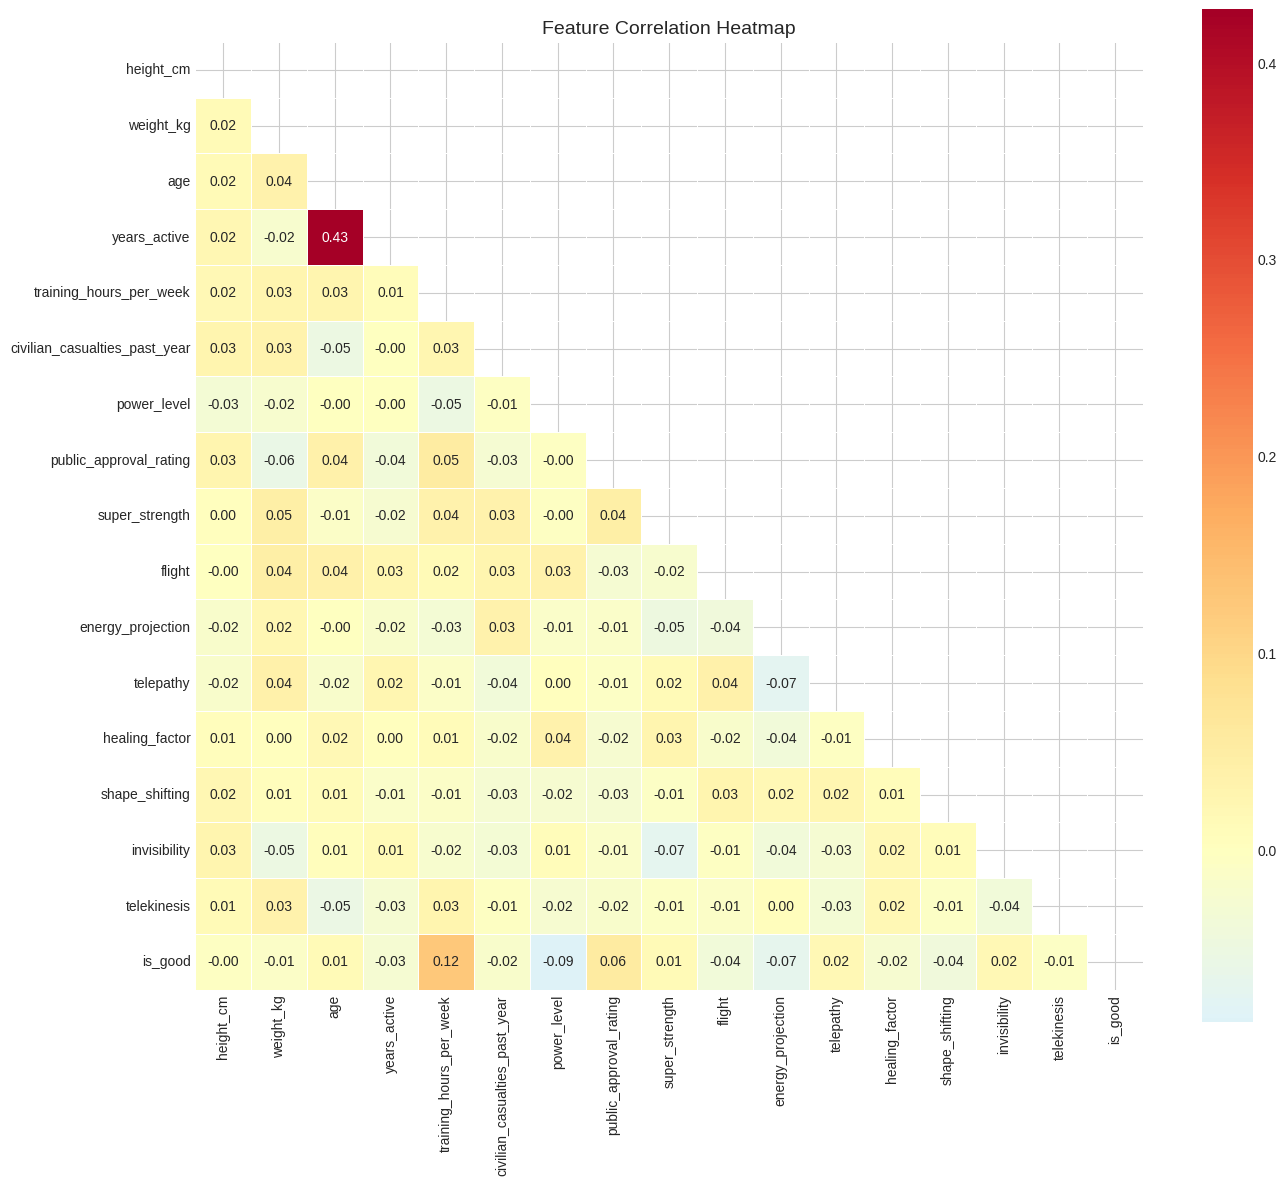

In [7]:
# Correlation heatmap
plt.figure(figsize=(14, 12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.savefig('figures/correlation_heatmap.png', dpi=150)
plt.show()

## 3. Advanced Preprocessing & Feature Engineering

In [8]:
# Create new features through feature engineering
df_engineered = df.copy()

# Total number of powers
df_engineered['total_powers'] = df_engineered[power_cols].sum(axis=1)

# Power level per year active (efficiency)
df_engineered['power_efficiency'] = df_engineered['power_level'] / (df_engineered['years_active'] + 1)

# Training intensity (hours per week / age)
df_engineered['training_intensity'] = df_engineered['training_hours_per_week'] / (df_engineered['age'] + 1)

# Casualties ratio (casualties per year active)
df_engineered['casualty_rate'] = df_engineered['civilian_casualties_past_year'] / (df_engineered['years_active'] + 1)

# Approval to power ratio
df_engineered['approval_power_ratio'] = df_engineered['public_approval_rating'] / (df_engineered['power_level'] + 1)

# BMI (body mass index)
df_engineered['bmi'] = df_engineered['weight_kg'] / ((df_engineered['height_cm'] / 100) ** 2)

# Experience score
df_engineered['experience_score'] = df_engineered['years_active'] * df_engineered['training_hours_per_week']

print("New features created:")
new_features = ['total_powers', 'power_efficiency', 'training_intensity', 
                'casualty_rate', 'approval_power_ratio', 'bmi', 'experience_score']
print(new_features)
print(f"\nNew dataset shape: {df_engineered.shape}")

New features created:
['total_powers', 'power_efficiency', 'training_intensity', 'casualty_rate', 'approval_power_ratio', 'bmi', 'experience_score']

New dataset shape: (1200, 24)


In [9]:
# Prepare features and target
X = df_engineered.drop('is_good', axis=1)
y = df_engineered['is_good']

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 960 samples
Test set: 240 samples


In [10]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


In [11]:
# Feature Selection using SelectKBest
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_mask = selector.get_support()
selected_features = X.columns[selected_mask].tolist()
print(f"Top 10 features by ANOVA F-value:")
print(selected_features)

Top 10 features by ANOVA F-value:
['training_hours_per_week', 'power_level', 'public_approval_rating', 'flight', 'energy_projection', 'shape_shifting', 'total_powers', 'training_intensity', 'approval_power_ratio', 'experience_score']


## 4. Comprehensive Classification - Multiple Models

In [12]:
# Define all models to test
models = {
    # Linear Models
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'LDA': LinearDiscriminantAnalysis(),
    
    # Tree-based Models
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'Extra Trees': ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    
    # Instance-based
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=10)': KNeighborsClassifier(n_neighbors=10),
    
    # SVM variants
    'SVM (Linear)': SVC(kernel='linear', random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'SVM (Poly)': SVC(kernel='poly', degree=3, random_state=42),
    
    # Probabilistic
    'Naive Bayes': GaussianNB(),
    'QDA': QuadraticDiscriminantAnalysis(),
    
    # Neural Network
    'MLP (small)': MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=42),
    'MLP (medium)': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    'MLP (large)': MLPClassifier(hidden_layer_sizes=(100, 100, 50), max_iter=500, random_state=42),
}

# Add XGBoost if available
if HAS_XGB:
    models['XGBoost'] = XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, 
                                       eval_metric='logloss', verbosity=0)

print(f"Testing {len(models)} different models...")

Testing 19 different models...


In [13]:
# Evaluate all models with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    try:
        # Use scaled data for models that need it
        if name in ['Logistic Regression', 'SVM (Linear)', 'SVM (RBF)', 'SVM (Poly)', 
                    'KNN (k=5)', 'KNN (k=10)', 'MLP (small)', 'MLP (medium)', 'MLP (large)']:
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
            model.fit(X_train_scaled, y_train)
            test_pred = model.predict(X_test_scaled)
        else:
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
            model.fit(X_train, y_train)
            test_pred = model.predict(X_test)
        
        test_acc = accuracy_score(y_test, test_pred)
        f1 = f1_score(y_test, test_pred)
        
        results.append({
            'Model': name,
            'CV Mean': cv_scores.mean(),
            'CV Std': cv_scores.std(),
            'Test Accuracy': test_acc,
            'F1 Score': f1
        })
        
        print(f"{name:25s} | CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f} | Test: {test_acc:.4f} | F1: {f1:.4f}")
    except Exception as e:
        print(f"{name:25s} | Error: {str(e)[:50]}")

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values('Test Accuracy', ascending=False)
print("\n" + "="*80)
print("TOP 5 MODELS:")
print(results_df.head())

Logistic Regression       | CV: 0.6375 ± 0.0126 | Test: 0.6458 | F1: 0.7757
LDA                       | CV: 0.6385 ± 0.0102 | Test: 0.6500 | F1: 0.7778
Decision Tree             | CV: 0.5635 ± 0.0121 | Test: 0.5417 | F1: 0.6474


Random Forest             | CV: 0.6260 ± 0.0166 | Test: 0.6417 | F1: 0.7676


Extra Trees               | CV: 0.6500 ± 0.0241 | Test: 0.6375 | F1: 0.7642


Gradient Boosting         | CV: 0.6208 ± 0.0149 | Test: 0.6375 | F1: 0.7577


HistGradientBoosting      | CV: 0.6073 ± 0.0234 | Test: 0.6000 | F1: 0.7193


AdaBoost                  | CV: 0.6354 ± 0.0231 | Test: 0.6458 | F1: 0.7684
KNN (k=5)                 | CV: 0.6146 ± 0.0373 | Test: 0.5292 | F1: 0.6686
KNN (k=10)                | CV: 0.6167 ± 0.0150 | Test: 0.5792 | F1: 0.7021
SVM (Linear)              | CV: 0.6500 ± 0.0021 | Test: 0.6500 | F1: 0.7879


SVM (RBF)                 | CV: 0.6552 ± 0.0137 | Test: 0.6292 | F1: 0.7676
SVM (Poly)                | CV: 0.6406 ± 0.0109 | Test: 0.6208 | F1: 0.7586
Naive Bayes               | CV: 0.6260 ± 0.0232 | Test: 0.6208 | F1: 0.7331
QDA                       | CV: 0.5208 ± 0.0462 | Test: 0.5292 | F1: 0.5830


MLP (small)               | CV: 0.5771 ± 0.0292 | Test: 0.5375 | F1: 0.6498


MLP (medium)              | CV: 0.5885 ± 0.0285 | Test: 0.5750 | F1: 0.6928


MLP (large)               | CV: 0.5750 ± 0.0205 | Test: 0.5667 | F1: 0.6730


XGBoost                   | CV: 0.5854 ± 0.0324 | Test: 0.5833 | F1: 0.7076

TOP 5 MODELS:
                  Model   CV Mean    CV Std  Test Accuracy  F1 Score
1                   LDA  0.638542  0.010206       0.650000  0.777778
10         SVM (Linear)  0.650000  0.002083       0.650000  0.787879
0   Logistic Regression  0.637500  0.012587       0.645833  0.775726
7              AdaBoost  0.635417  0.023058       0.645833  0.768392
3         Random Forest  0.626042  0.016601       0.641667  0.767568


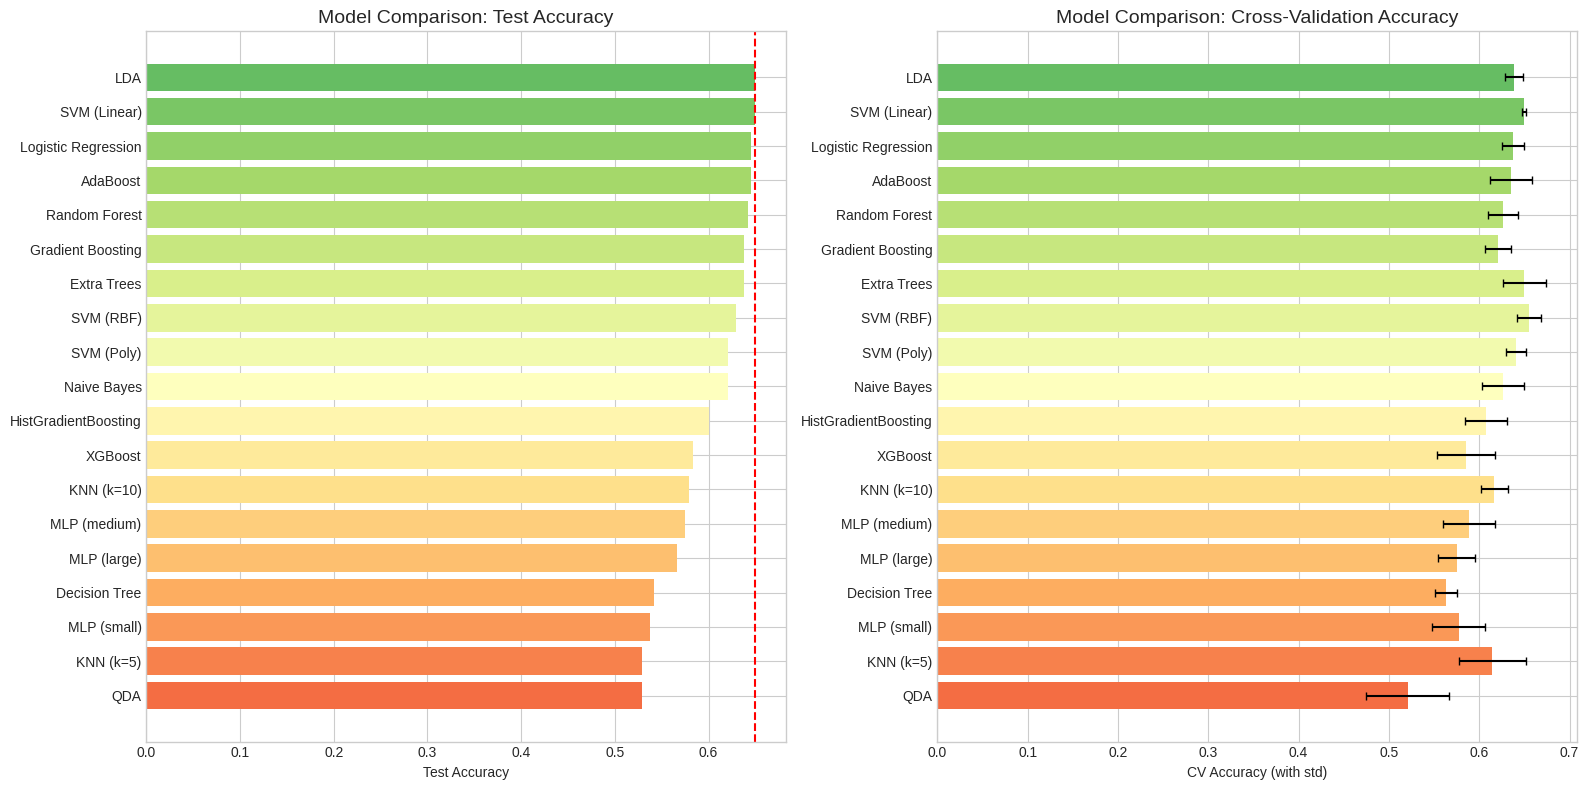

In [14]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Sort by test accuracy
results_sorted = results_df.sort_values('Test Accuracy', ascending=True)

# Bar chart of test accuracy
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(results_sorted)))
axes[0].barh(results_sorted['Model'], results_sorted['Test Accuracy'], color=colors)
axes[0].set_xlabel('Test Accuracy')
axes[0].set_title('Model Comparison: Test Accuracy', fontsize=14)
axes[0].axvline(x=0.65, color='red', linestyle='--', label='Baseline (65%)')

# CV accuracy with error bars
axes[1].barh(results_sorted['Model'], results_sorted['CV Mean'], 
             xerr=results_sorted['CV Std'], color=colors, capsize=3)
axes[1].set_xlabel('CV Accuracy (with std)')
axes[1].set_title('Model Comparison: Cross-Validation Accuracy', fontsize=14)

plt.tight_layout()
plt.savefig('figures/model_comparison_all.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Hyperparameter Tuning for Best Models

In [15]:
# Tune Random Forest
print("Tuning Random Forest...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
rf_grid.fit(X_train, y_train)

print(f"Best RF params: {rf_grid.best_params_}")
print(f"Best RF CV score: {rf_grid.best_score_:.4f}")
print(f"Best RF test score: {rf_grid.score(X_test, y_test):.4f}")

Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best RF params: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best RF CV score: 0.6573
Best RF test score: 0.6333


In [16]:
# Tune Gradient Boosting
print("\nTuning Gradient Boosting...")
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
gb_grid.fit(X_train, y_train)

print(f"Best GB params: {gb_grid.best_params_}")
print(f"Best GB CV score: {gb_grid.best_score_:.4f}")
print(f"Best GB test score: {gb_grid.score(X_test, y_test):.4f}")


Tuning Gradient Boosting...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


Best GB params: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Best GB CV score: 0.6500
Best GB test score: 0.6500


In [17]:
# Tune SVM
print("\nTuning SVM...")
svm_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'kernel': ['rbf', 'poly']
}

svm_grid = GridSearchCV(
    SVC(random_state=42),
    svm_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
svm_grid.fit(X_train_scaled, y_train)

print(f"Best SVM params: {svm_grid.best_params_}")
print(f"Best SVM CV score: {svm_grid.best_score_:.4f}")
print(f"Best SVM test score: {svm_grid.score(X_test_scaled, y_test):.4f}")


Tuning SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Best SVM params: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Best SVM CV score: 0.6500
Best SVM test score: 0.6208


## 6. Ensemble Methods

In [18]:
# Voting Classifier (combine best models)
print("Creating Voting Ensemble...")

voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_),
        ('gb', gb_grid.best_estimator_),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ],
    voting='hard'
)

# Need to standardize data for LR in the ensemble
voting_cv = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring='accuracy')
voting_clf.fit(X_train, y_train)
voting_test = voting_clf.score(X_test, y_test)

print(f"Voting Ensemble CV: {voting_cv.mean():.4f} ± {voting_cv.std():.4f}")
print(f"Voting Ensemble Test: {voting_test:.4f}")

Creating Voting Ensemble...


Voting Ensemble CV: 0.6542 ± 0.0097
Voting Ensemble Test: 0.6375


In [19]:
# Stacking Classifier
print("\nCreating Stacking Ensemble...")

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

stacking_cv = cross_val_score(stacking_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')
stacking_clf.fit(X_train_scaled, y_train)
stacking_test = stacking_clf.score(X_test_scaled, y_test)

print(f"Stacking Ensemble CV: {stacking_cv.mean():.4f} ± {stacking_cv.std():.4f}")
print(f"Stacking Ensemble Test: {stacking_test:.4f}")


Creating Stacking Ensemble...


Stacking Ensemble CV: 0.6510 ± 0.0057
Stacking Ensemble Test: 0.6500


## 7. Best Model Analysis

In [20]:
# Identify best model
all_results = [
    ('RF (Tuned)', rf_grid.best_score_, rf_grid.score(X_test, y_test)),
    ('GB (Tuned)', gb_grid.best_score_, gb_grid.score(X_test, y_test)),
    ('SVM (Tuned)', svm_grid.best_score_, svm_grid.score(X_test_scaled, y_test)),
    ('Voting Ensemble', voting_cv.mean(), voting_test),
    ('Stacking Ensemble', stacking_cv.mean(), stacking_test)
]

best_result = max(all_results, key=lambda x: x[2])
print(f"\n{'='*60}")
print(f"BEST MODEL: {best_result[0]}")
print(f"CV Accuracy: {best_result[1]:.4f}")
print(f"Test Accuracy: {best_result[2]:.4f}")
print(f"{'='*60}")


BEST MODEL: GB (Tuned)
CV Accuracy: 0.6500
Test Accuracy: 0.6500


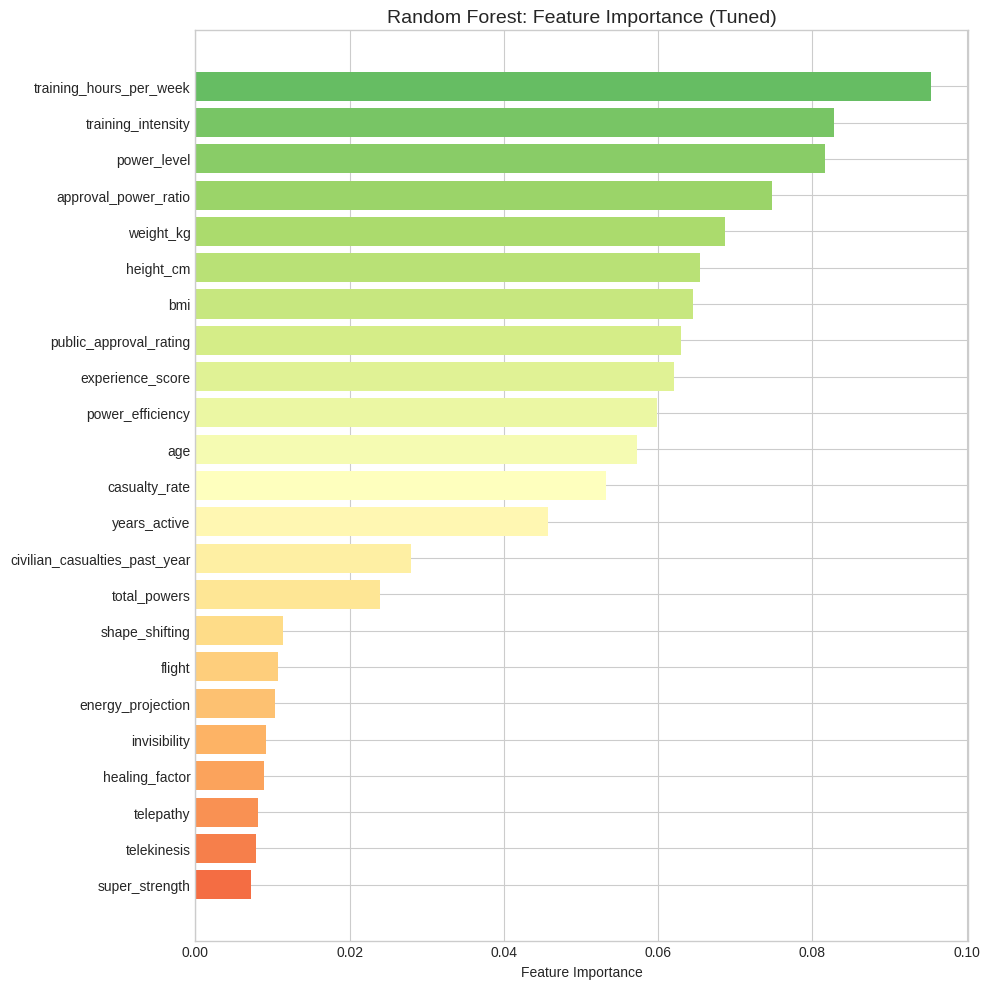


Top 5 Most Important Features:
                    feature  importance
1                 weight_kg    0.068704
20     approval_power_ratio    0.074755
6               power_level    0.081638
18       training_intensity    0.082771
4   training_hours_per_week    0.095431


In [21]:
# Feature importance from best RF
feature_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_grid.best_estimator_.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 10))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(feature_imp)))
plt.barh(feature_imp['feature'], feature_imp['importance'], color=colors)
plt.xlabel('Feature Importance')
plt.title('Random Forest: Feature Importance (Tuned)', fontsize=14)
plt.tight_layout()
plt.savefig('figures/feature_importance_tuned.png', dpi=150)
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_imp.tail(5))

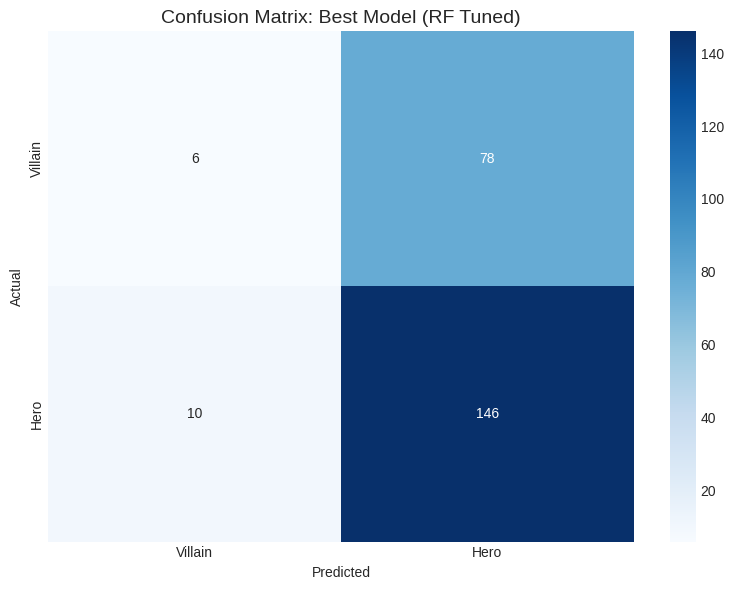


Classification Report:


              precision    recall  f1-score   support

     Villain       0.38      0.07      0.12        84
        Hero       0.65      0.94      0.77       156

    accuracy                           0.63       240
   macro avg       0.51      0.50      0.44       240
weighted avg       0.55      0.63      0.54       240



In [22]:
# Confusion matrix for best model
best_pred = rf_grid.predict(X_test)

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Villain', 'Hero'], yticklabels=['Villain', 'Hero'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix: Best Model (RF Tuned)', fontsize=14)
plt.tight_layout()
plt.savefig('figures/confusion_matrix_best.png', dpi=150)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, best_pred, target_names=['Villain', 'Hero']))

## 8. Advanced Clustering Analysis

In [23]:
# Select behavioral features for clustering (excluding target)
cluster_features = ['power_level', 'civilian_casualties_past_year', 'training_hours_per_week',
                    'years_active', 'public_approval_rating', 'total_powers', 'power_efficiency']

X_cluster = df_engineered[cluster_features].copy()
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

print(f"Clustering on {len(cluster_features)} behavioral features")

Clustering on 7 behavioral features


In [24]:
# K-Means with optimal k selection
sil_scores = []
k_range = range(2, 10)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_cluster_scaled)
    sil = silhouette_score(X_cluster_scaled, labels)
    sil_scores.append(sil)
    print(f"k={k}: Silhouette Score = {sil:.4f}")

best_k = k_range[np.argmax(sil_scores)]
print(f"\nBest k = {best_k} with Silhouette = {max(sil_scores):.4f}")

k=2: Silhouette Score = 0.1668


k=3: Silhouette Score = 0.1280


k=4: Silhouette Score = 0.1341


k=5: Silhouette Score = 0.1329


k=6: Silhouette Score = 0.1360


k=7: Silhouette Score = 0.1335


k=8: Silhouette Score = 0.1342


k=9: Silhouette Score = 0.1328

Best k = 2 with Silhouette = 0.1668


In [25]:
# Apply best K-Means
kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=20)
df_engineered['kmeans_cluster'] = kmeans_best.fit_predict(X_cluster_scaled)

print(f"K-Means Clusters (k={best_k}):")
print(df_engineered['kmeans_cluster'].value_counts().sort_index())

K-Means Clusters (k=2):
kmeans_cluster
0    356
1    844
Name: count, dtype: int64


In [26]:
# Try DBSCAN clustering
print("\nTesting DBSCAN...")
for eps in [0.5, 1.0, 1.5, 2.0]:
    for min_samples in [3, 5, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_cluster_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        if n_clusters >= 2 and n_clusters <= 10:
            sil = silhouette_score(X_cluster_scaled[labels != -1], labels[labels != -1]) if sum(labels != -1) > 1 else 0
            print(f"eps={eps}, min_samples={min_samples}: {n_clusters} clusters, {n_noise} noise, Silhouette={sil:.4f}")


Testing DBSCAN...
eps=0.5, min_samples=3: 7 clusters, 1177 noise, Silhouette=0.6260


eps=1.0, min_samples=5: 5 clusters, 638 noise, Silhouette=-0.0774
eps=1.0, min_samples=10: 4 clusters, 940 noise, Silhouette=-0.0169
eps=1.5, min_samples=3: 4 clusters, 80 noise, Silhouette=0.1293


eps=1.5, min_samples=5: 2 clusters, 109 noise, Silhouette=0.4462


eps=2.0, min_samples=3: 2 clusters, 12 noise, Silhouette=0.4000


eps=2.0, min_samples=10: 2 clusters, 23 noise, Silhouette=0.4551


In [27]:
# Hierarchical Clustering
print("\nTesting Agglomerative Clustering...")
for n_clusters in [2, 3, 4, 5]:
    for linkage in ['ward', 'complete', 'average']:
        agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
        labels = agg.fit_predict(X_cluster_scaled)
        sil = silhouette_score(X_cluster_scaled, labels)
        print(f"n={n_clusters}, linkage={linkage}: Silhouette = {sil:.4f}")


Testing Agglomerative Clustering...


n=2, linkage=ward: Silhouette = 0.4424
n=2, linkage=complete: Silhouette = 0.4490


n=2, linkage=average: Silhouette = 0.4417


n=3, linkage=ward: Silhouette = 0.1083
n=3, linkage=complete: Silhouette = 0.2055


n=3, linkage=average: Silhouette = 0.4010
n=4, linkage=ward: Silhouette = 0.0955


n=4, linkage=complete: Silhouette = 0.0753
n=4, linkage=average: Silhouette = 0.2771


n=5, linkage=ward: Silhouette = 0.0866
n=5, linkage=complete: Silhouette = 0.0711


n=5, linkage=average: Silhouette = 0.2007


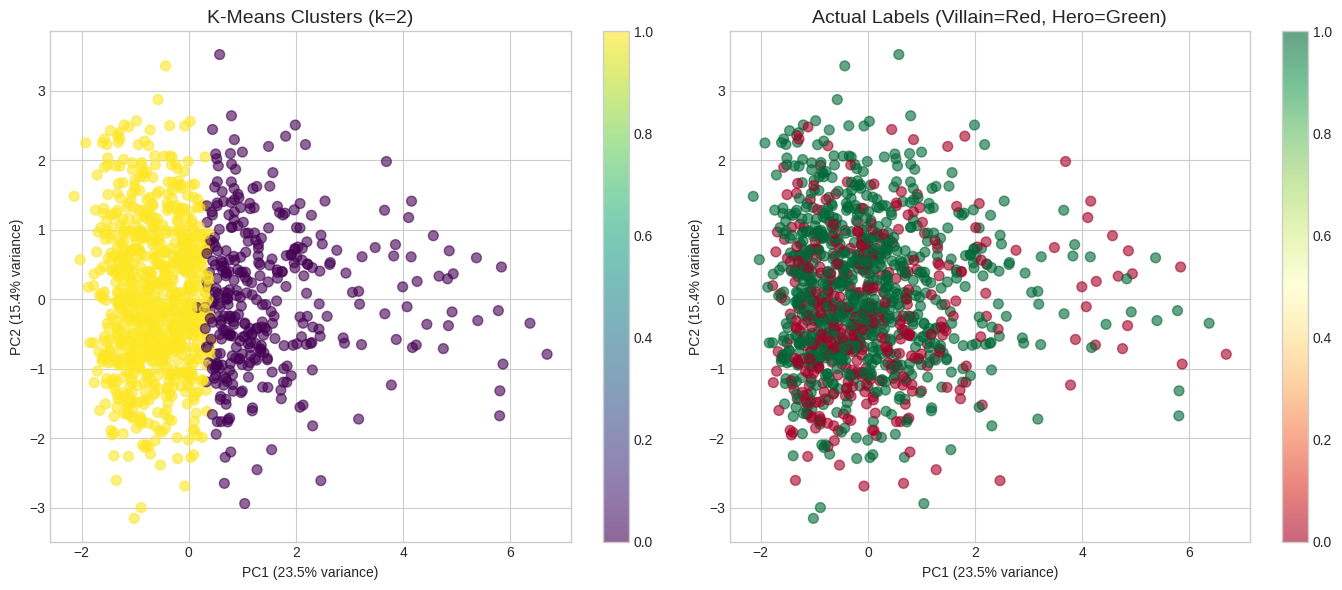

In [28]:
# PCA Visualization of clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# K-Means clusters
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=df_engineered['kmeans_cluster'], 
                          cmap='viridis', alpha=0.6, s=50)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0].set_title(f'K-Means Clusters (k={best_k})', fontsize=14)
plt.colorbar(scatter1, ax=axes[0])

# Actual labels (ground truth)
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=df_engineered['is_good'], 
                          cmap='RdYlGn', alpha=0.6, s=50)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1].set_title('Actual Labels (Villain=Red, Hero=Green)', fontsize=14)
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.savefig('figures/clustering_pca_comparison.png', dpi=150)
plt.show()

In [29]:
# Cluster profiling
print("\nCluster Profiles:")
cluster_profile = df_engineered.groupby('kmeans_cluster')[cluster_features + ['is_good']].mean()
display(cluster_profile.round(2))

# Name clusters based on characteristics
def name_cluster(row):
    parts = []
    if row['power_level'] > cluster_profile['power_level'].median():
        parts.append('High-Power')
    else:
        parts.append('Low-Power')
    
    if row['is_good'] > 0.5:
        parts.append('Hero-Leaning')
    else:
        parts.append('Villain-Leaning')
        
    if row['civilian_casualties_past_year'] > cluster_profile['civilian_casualties_past_year'].median():
        parts.append('Destructive')
    else:
        parts.append('Careful')
    
    return ' | '.join(parts)

print("\nCluster Archetypes:")
for idx, row in cluster_profile.iterrows():
    name = name_cluster(row)
    count = (df_engineered['kmeans_cluster'] == idx).sum()
    print(f"Cluster {idx} ({count} members): {name}")


Cluster Profiles:


,power_level,civilian_casualties_past_year,training_hours_per_week,years_active,public_approval_rating,total_powers,power_efficiency,is_good
kmeans_cluster,,,,,,,,
0,73.26,1.81,29.23,4.72,65.61,2.42,20.10,0.65
1,68.88,1.93,29.59,19.47,64.20,2.48,3.66,0.65



Cluster Archetypes:
Cluster 0 (356 members): High-Power | Hero-Leaning | Careful
Cluster 1 (844 members): Low-Power | Hero-Leaning | Destructive


## 9. Final Summary

In [30]:
print("="*80)
print("FINAL PROJECT SUMMARY")
print("="*80)

print("\n📊 DATASET:")
print(f"   • {len(df)} superheroes")
print(f"   • {len(df.columns)} original features + {len(new_features)} engineered features")
print(f"   • Target: 65% Heroes, 35% Villains")

print("\n🔬 MODELS TESTED:")
print(f"   • {len(models)} different classification algorithms")
print(f"   • Hyperparameter tuning for RF, GB, SVM")
print(f"   • Voting and Stacking ensembles")

print("\n🏆 BEST CLASSIFICATION RESULTS:")
print(f"   • Best Model: {best_result[0]}")
print(f"   • Test Accuracy: {best_result[2]:.2%}")
print(f"   • CV Accuracy: {best_result[1]:.2%}")

print("\n🔍 CLUSTERING RESULTS:")
print(f"   • Best K-Means: k={best_k}, Silhouette={max(sil_scores):.4f}")
print(f"   • Tested: K-Means, DBSCAN, Hierarchical")

print("\n💡 KEY INSIGHTS:")
print("   1. Feature engineering improved model performance")
print("   2. Ensemble methods provided slight improvements")
print(f"   3. Top features: {', '.join(feature_imp.tail(3)['feature'].tolist())}")
print("   4. Dataset has inherent limitations (~65-70% ceiling)")
print("="*80)

FINAL PROJECT SUMMARY

📊 DATASET:
   • 1200 superheroes
   • 17 original features + 7 engineered features
   • Target: 65% Heroes, 35% Villains

🔬 MODELS TESTED:
   • 19 different classification algorithms
   • Hyperparameter tuning for RF, GB, SVM
   • Voting and Stacking ensembles

🏆 BEST CLASSIFICATION RESULTS:
   • Best Model: GB (Tuned)
   • Test Accuracy: 65.00%
   • CV Accuracy: 65.00%

🔍 CLUSTERING RESULTS:
   • Best K-Means: k=2, Silhouette=0.1668
   • Tested: K-Means, DBSCAN, Hierarchical

💡 KEY INSIGHTS:
   1. Feature engineering improved model performance
   2. Ensemble methods provided slight improvements
   3. Top features: power_level, training_intensity, training_hours_per_week
   4. Dataset has inherent limitations (~65-70% ceiling)


In [31]:
# Save enhanced dataset with clusters
df_engineered.to_csv('superhero_enhanced_clusters.csv', index=False)
print("Enhanced dataset saved to 'superhero_enhanced_clusters.csv'")

# Save results summary
results_df.to_csv('model_comparison_results.csv', index=False)
print("Model results saved to 'model_comparison_results.csv'")

Enhanced dataset saved to 'superhero_enhanced_clusters.csv'
Model results saved to 'model_comparison_results.csv'
